# SpacePy Tutorial -- SWMF Dynamics

- https://github.com/heliophysicsPy/summer-school-24/blob/main/spacepy-tutorial/SpacePy%20-%20SWMF%20Dynamics.md

The data that accompanies this tutorial has been archieved at Zenodo.com with the following DOI: 10.5281/zenodo.7693203. 
[Users may download the data here.](https://doi.org/10.5281/zenodo.7693203)

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7693203.svg)](https://doi.org/10.5281/zenodo.7693203)

# Background
The Space Weather Modeling Framework (SWMF) is a powerful coupled-model approach for investigating the system dynamics of the magnteophere, ionosphere, ring current, and other regions of geospace. It couples several models together to create self-consistent simulations of geospace. Most commonly, this includes BATS-R-US, the Ridley Ionosphere Model (RIM), and one of several ring current models. The output from these simulations can be complicated to work with as they have different formats, different values, and different approaches to analysis. This tutorial demonstrates how to use the Spacepy Pybats module to explore and analyze SWMF output.

Specifically, we're going to explore the result set from [Welling et al., 2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020SW002489), Figures 2 and 3. The SWMF was used to explore the geospace response to a hypothetical worst-case-scenario storm sudden commencement. A subset of outputs are provided in the tutorial data directory representing the two simulations explored in the paper: an extreme CME arrival with *northward* IMF, and an extreme CME arrival with *southward* IMF. 

For our purposes, let's assume that the dataset has just been downloaded from the supercomputing environment. We do not know if the results are valid and reasonable yet. We need to first confirm that the results are reasonable. Then we want to illustrate the magnetosphere's response to the CMEs, including the compression of the dayside magnetopause, the formation of Region 1 Field-Aligned Currents (R1 FACs), and the time dynamics of the magnetopause. This will require opening files from BATS-R-US and RIM, creating 2D figures, and performing field-line tracing to see the open-closed boundary.

Concepts explored in this tutorial include,

  - Opening SWMF output files using [spacepy.pybats](https://spacepy.github.io/pybats.html).
  - Using the features of [spacepy.datamodel](https://spacepy.github.io/datamodel.html) to explore unfamiliar data sets.
  - Using [spacepy.pybats](https://spacepy.github.io/pybats.html) classes to analyze MHD output, extract values at arbitrary points, and trace magnetic field lines.
  - Various features of [spacepy.plot](https://spacepy.github.io/plot.html), including the `target` keyword argument syntax.
  - Classes and inheritance in Python.

## Setup

The first thing we need to do is install SpacePy. If SpacePy is already installed, you can remove that line.

As is the case for the other Spacepy tutorials, we use a single directory containing all the data for this tutorial. This data is available [from Zenodo](https://doi.org/10.5281/zenodo.7693203). Untar it and update the `tutorial_data` variable. Next, we create a variable to point to that directory - you will need to customize this to correspond to the locaction of the data on your machine.

In [ ]:
import os.path
# Update this line to point to the directory where you put the tutorial data; it will be used throughout
# This directory should contain swmf_ssi_north, swmf_ssi_south, etc.
tutorial_data = os.path.expanduser('./spacepy_tutorial/')

Next, import the pertinent modules that will support this tutorial.

In [ ]:
# Import cpickle library:
import pickle

# Import file path handling:
import os.path

# Import numpy:
import numpy as np

# Plotting utilities:
import matplotlib.pyplot as plt
import spacepy.plot as splot
from matplotlib import gridspec

# Top-level and model-specific Pybats modules:
from spacepy import pybats
from spacepy.pybats import bats, rim

# For convenient notebook display and pretty out-of-the-box plots...
%matplotlib inline
splot.style('default')

## Diving into the data

Our first step is to look at the output files we have and determine what values they contain. In the example data folder, there are two folders: `swmf_ssi_north` and `swmf_ssi_south`. The "north" folder is an extreme SSI with northward IMF, the "south" folder are results with southward IMF. Each is organized in a similar manner to real world SWMF output directories. There is a sub-folder for the "global magnetosphere" component (`GM`) and the "ionospheric electrodynamics" component (`IE`). For this simulation, the codes used for these components are *BATS-R-US* and the *Ridley Ionosphere Model (RIM)*, respectively. Users may see additional folders if other components were included (e.g., `IM`, `PW`, etc.). Output from each code is placed into the respective folders.

Because the SWMF combines independently developed codes, we are often presented with a variety of data files of a variety of formats. Further, because these codes are highly configurable, the contents are often not clear to people not privvy to the simuation configuration. 
It may be instructive to [peruse the manual](http://herot.engin.umich.edu/~gtoth/SWMF/doc/SWMF.pdf)  to see just how many different output types are available (see the `#SAVEPLOT` command entries).
Our first job is to determine how to open these files and then see what values they contain. Peeking into the directories, this is what we see:

From BATS-R-US (`GM` directory):

- `y0*.outs` files: 2d cuts of the MHD result in the Y=0 plane.
- `log*.log` files: Timeseries of diagnostic values, Dst.

From RIM (`IE` directory):

- `it*.idl.gz` files: 2d ionospheric electrodynamic values.

Each of these has its own format type, either binary (as in the case with the `.outs` files) or ascii. Some formats are common across different models within the SWMF. In these cases, we can use the base classes within `pybats` to open and explore the contents. Specifically, `.out` and `.outs` files, either binary or ascii, can be opened with the`spacepy.pybats.IdlFile` class. Simple log files can often be loaded with the `spacepy.pybats.LogFile` class. Loading such files is a simple affair:

In [ ]:
# Some convenience variables to help us keep organized:
path_north = os.path.join(tutorial_data, 'swmf_ssi_north')
path_south = os.path.join(tutorial_data, 'swmf_ssi_south')

# Open the log file:
log = pybats.LogFile(os.path.join(path_north, 'GM', 'log_e20150321-054500.log'))

# Open the 2D slice files:
mhd = pybats.IdlFile(os.path.join(path_north, 'GM', 'y=0_mhd_1_e20150321-060040-000_20150321-060510-000.outs'))

*Note: When writing scripts, I often just use the glob module to avoid looking up every precise file name.*

The `log` and `mhd` objects are built on Spacepy's data model, giving us powerful tools to explore their contents.

- The `.attrs` object attributes list global-level attributes about the files.
- Values are accessed via key-value syntax, like dictionaries. The `.keys()` method will yield available values.
- Each value has its own `.attrs` attribute that gives value-level information when available.
- The `.tree()` object method can make short work of unravelling what's in the file.

Let's see what this looks like:

In [ ]:
mhd.attrs # Print out object-level attributes

{'file': './spacepy_tutorial/swmf_ssi_north\\GM\\y=0_mhd_1_e20150321-060040-000_20150321-060510-000.outs',
 'format': 'bin',
 'iter_range': [353680, 375666],
 'runtime_range': [940.0, 1210.0],
 'time_range': [datetime.datetime(2015, 3, 21, 6, 0, 40),
  datetime.datetime(2015, 3, 21, 6, 5, 10)],
 'nframe': 4,
 'iters': array([353680, 356990, 359404, 375666]),
 'runtimes': array([ 940.,  980., 1010., 1210.], dtype=float32),
 'times': array([datetime.datetime(2015, 3, 21, 6, 0, 40),
        datetime.datetime(2015, 3, 21, 6, 1, 20),
        datetime.datetime(2015, 3, 21, 6, 1, 50),
        datetime.datetime(2015, 3, 21, 6, 5, 10)], dtype=object),
 'iter': 353680,
 'runtime': 940.0,
 'ndim': 2,
 'nparam': 5,
 'nvar': 11,
 'header': 'R R R Mp/cc km/s km/s km/s nT nT nT nPa uA/m2 uA/m2 uA/m2                                                                                                                                                                                                             

In [ ]:
log.attrs # Same, but for our log file.

{'file': './spacepy_tutorial/swmf_ssi_north\\GM\\log_e20150321-054500.log',
 'descrip': 'Volume averages, fluxes, etc\n',
 'npts': 1621}

In [ ]:
mhd.keys() # Look at the values stored in the object

dict_keys(['grid', 'x', 'z', 'Rho', 'Ux', 'Uy', 'Uz', 'Bx', 'By', 'Bz', 'P', 'jx', 'jy', 'jz'])

In [ ]:
mhd.tree(verbose=True, attrs=True) # Print out the "tree" representation of the file

+
:|____clight (numpy.float64 ())
:|____cuty (numpy.float64 ())
:|____file (str [92])
:|____format (str [3])
:|____g (numpy.float64 ())
:|____header (str [500])
:|____iframe (int)
:|____iter (numpy.int32 ())
:|____iter_range (list [2])
:|____iters (numpy.ndarray (4,))
:|____ndim (numpy.int32 ())
:|____nframe (int)
:|____nparam (numpy.int32 ())
:|____nvar (numpy.int32 ())
:|____r (numpy.float64 ())
:|____runtime (numpy.float32 ())
:|____runtime_range (list [2])
:|____runtimes (numpy.ndarray (4,))
:|____strtime (str [15])
:|____time (datetime.datetime)
:|____time_range (list [2])
:|____times (numpy.ndarray (4,))
:|____xSI (numpy.float64 ())
|____Bx (spacepy.datamodel.dmarray (25216,))
    :|____units (str [2])
|____By (spacepy.datamodel.dmarray (25216,))
    :|____units (str [2])
|____Bz (spacepy.datamodel.dmarray (25216,))
    :|____units (str [2])
|____P (spacepy.datamodel.dmarray (25216,))
    :|____units (str [3])
|____Rho (spacepy.datamodel.dmarray (25216,))
    :|____units (str [5]

Each value is a `spacepy.pybats.dmarray` object- this is a subclassed `numpy` array object but with `.attrs` attributes and other functionality. We can continue our exploration of the files:

In [ ]:
mhd['P'].attrs

{'units': 'nPa'}

In [ ]:
log['dst']

dmarray([  1.8156 ,   1.84898,   1.90588, ..., 145.429  , 145.428  ,
         145.424  ])

With the data available to us, we can plot and manipulate as would normally would with Numpy arrays and Matplotlib.

## Series of snapshots: `.out` vs. `.outs`

Before we continue, we need to discuss our MHD data file. It's actually a *time series* of data files concatenated together from previously separate files with the suffix `.out` (no *s* on *out*). Each snapshot of the results is called a *frame*. We need to be able understand how many frames are stored in the file, know what times they represent, and have a way to switch between them. As far as understanding the number and time stamps of the frames, that information is stored in the object-level attributes:

In [ ]:
print(f"There are {mhd.attrs['nframe']} frames in this file.")
mhd.attrs['times']

There are 4 frames in this file.


array([datetime.datetime(2015, 3, 21, 6, 0, 40),
       datetime.datetime(2015, 3, 21, 6, 1, 20),
       datetime.datetime(2015, 3, 21, 6, 1, 50),
       datetime.datetime(2015, 3, 21, 6, 5, 10)], dtype=object)

Conveniently, this file contains the precise epochs we wish to plot.

There's also information about the currently loaded frame:

In [ ]:
print(f"Currently loaded frame {mhd.attrs['iframe']} representing T={mhd.attrs['time']}")

Currently loaded frame 0 representing T=2015-03-21 06:00:40


We can switch frames using the `switch_frame()` object method. This will load only the data from the file corresponding to that frame, helping to manage memory usage on large (hundreds of gigabyte) files. Following Python conventions, we use zero-based indexing.

In [ ]:
mhd.switch_frame(3)
print(f"Currently loaded frame  is now #{mhd.attrs['iframe']} representing T={mhd.attrs['time']}")

Currently loaded frame  is now #3 representing T=2015-03-21 06:05:10


## Find the right class for the job
The above syntax gets us to the data, but doesn't do us any favors in terms of doing actual work. Further, our RIM data is not in a common data format, so we haven't been able to open that data yet. Let's take a moment to see how *model- and output-specific classes* enable advanced features and powerful plotting methods. 

Our MHD data is from BATS-R-US, meaning we should turn to the *model-specific submodule* of pybats: `spacepy.pybats.bats`. Recognizing that the MHD files are 2D cuts, we can jump to the `spacepy.pybats.bats.Bats2d` class, which inherits from the `IdlFile` class and adds a lot of functionality via object methods. Exploring what is available is as easy as using tab-complete and docstrings:

In [ ]:
# Re-open our MHD file as a Bats2d object.
mhd = bats.Bats2d(os.path.join(path_north, 'GM', 'y=0_mhd_1_e20150321-060040-000_20150321-060510-000.outs'))
mhd.calc_b() # Calculate the total magnetic field and unit vector

mhd['bx_hat']

dmarray([-6.6306596e-03, -3.5073753e-03, -2.0923500e-03, ...,
          1.2068444e-06,  9.4852032e-07,  4.4194317e-07], dtype=float32)

Similarly, code-specific modules allow us to read our ionosphere output:

In [ ]:
iono = rim.Iono(os.path.join(path_north, 'IE', 'it150321_060040_000.idl.gz'))
iono.tree(attrs=True)

+
:|____file
:|____iter
:|____nphi
:|____ntheta
:|____nvars
:|____simtime
:|____time
:|____title
|____n_ave-e
    :|____units
|____n_conjugate dlat
    :|____units
|____n_conjugate dlon
    :|____units
|____n_e-flux
    :|____units
|____n_ionnumflux
    :|____units
|____n_jouleheat
    :|____units
|____n_jr
    :|____units
|____n_phi
    :|____units
|____n_psi
    :|____units
|____n_rt 1/b
    :|____units
|____n_rt p
    :|____units
|____n_rt rho
    :|____units
|____n_sigmah
    :|____units
|____n_sigmap
    :|____units
|____n_theta
    :|____units
|____s_ave-e
    :|____units
|____s_conjugate dlat
    :|____units
|____s_conjugate dlon
    :|____units
|____s_e-flux
    :|____units
|____s_ionnumflux
    :|____units
|____s_jouleheat
    :|____units
|____s_jr
    :|____units
|____s_phi
    :|____units
|____s_psi
    :|____units
|____s_rt 1/b
    :|____units
|____s_rt p
    :|____units
|____s_rt rho
    :|____units
|____s_sigmah
    :|____units
|____s_sigmap
    :|____units
|____s_theta
 

In general, always seek the class specific to the model and output type in question. Fall back to generic classes if nothing specific is available. For example, are you trying to look at model results for the PWOM model? Use `spacepy.pybats.pwom` and look for classes associated with your output file type. Don't see a class related to your output type? Fall back to generic classes within `spacepy.pybats`. Is your output file a different format then the standard SWMF output types? Request a new sub-module or class. Better yet, draft one up yourself and submit a pull request via Github!
> **Pybats Hint:** Always seek the class specific to the model and output type in question. Fall back to generic classes if nothing specific is available.

### Plotting

The fundamental goal of Pybats is to provide the user access to data in the various SWMF output files. At that point, you can use Matplotlib to create line plots, contours, etc. However, many helper methods exist to expedite this process greatly. Generally, these are methods that begin with `add_[plot type]`. Look for those methods as major time savers. These methods typically return matplotlib objects such as the figure and axes objects, lines, contours, and other components. This allows for further configuration of plots.

Any `add_[plot type]` object method takes advantage of Spacepy's `set_target()` function. In short, the default behavior of our plotting methods is to create a new figure and new axis. We can use the `target=` keyword argument to set a specific figure *or* axes on which to place the plot. Additionally, the `loc=` keyword argument can be used to specify the subplot location on a figure in the usual Matplotlib way. 

To exemplify this, let's create some example figures:

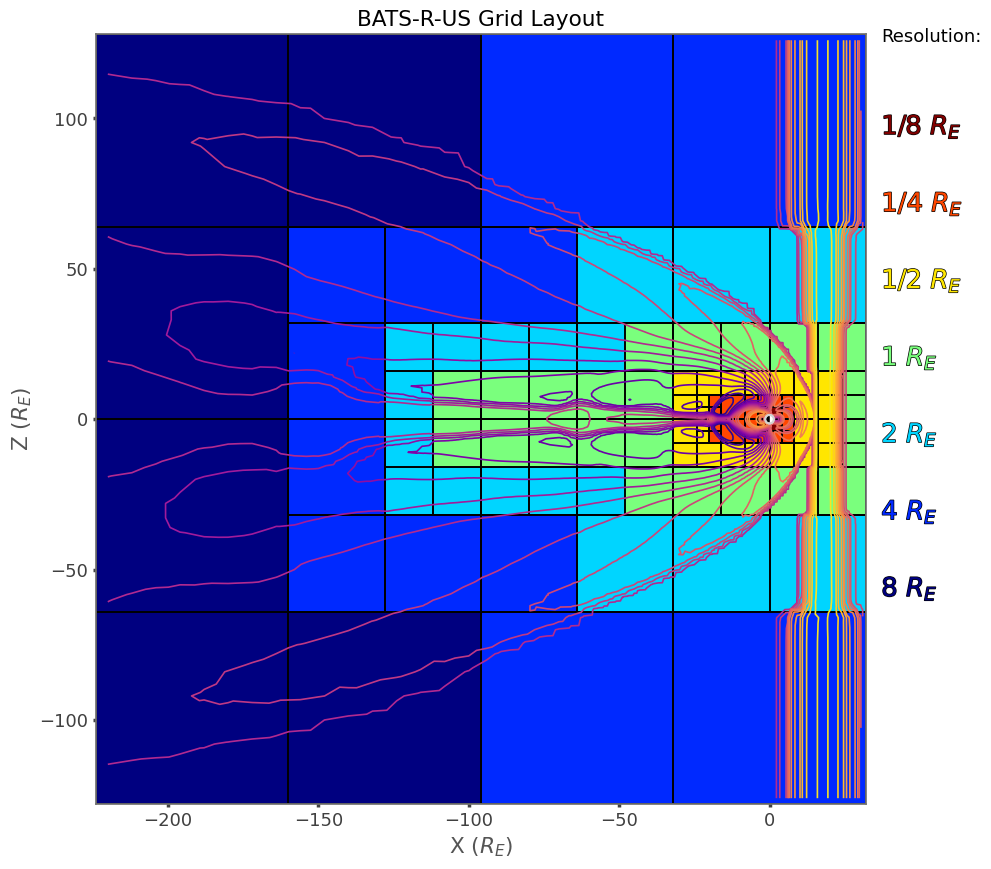

In [ ]:
# Add a summary plot of the grid resolution of BATS-R-US for the first epoch in our output file:
fig, ax = mhd.add_grid_plot()

# Over-plot unfilled contours of pressure using a log scale and only 21 contour levels:
mhd.add_contour('x', 'z', 'p', 21, dolog=True, target=ax, filled=False);

In this simple example, we first plot a diagram of the grid resolution where each region represents an area where the grid spacing is constant within. This method returns the figure and axes objects, which we capture as new variables. Then, we *overplot* pressure on the same axes, aided by the `target` keyword syntax. At this time in the simulation, the extreme CME conditions are making first contact with bowshock. We see the impact of grid resolution: the shock wave is broader in regions of lower spatial resolution, and our contours get noisier in low-resolution regions.

Let's do this again, but instead look at the magnetic field lines and ionospheric Birkeland currents:

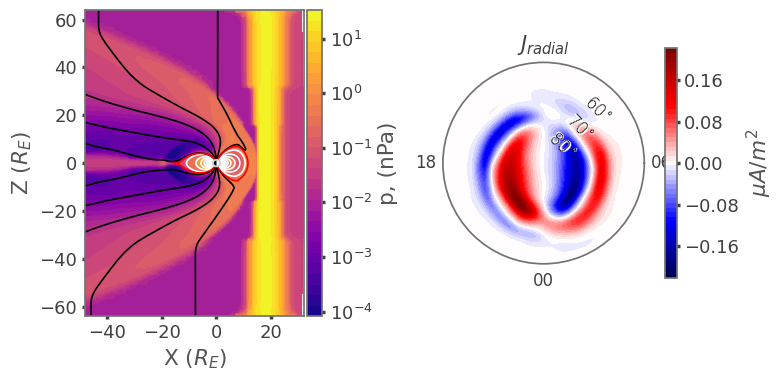

In [ ]:
# Create a new figure:
fig = plt.figure(figsize=[8,4])

# Add the magnetosphere to the left-hand side via a contour of thermal pressure.
# Use keyword arguments to add a color bar, use a log scale, and zoom in on the region of interest.
# Method returns four different matplotlib objects.
fig, ax, cont, cbar = mhd.add_contour('x', 'z', 'p', target=fig, loc=121, dolog=True, add_cbar=True, xlim=[-48, 32], ylim=[-64, 64])

# Add magnetic field lines using specialized object methods:
mhd.add_b_magsphere(target=ax)

# Add Birkeland currents to the right-hand side:
iono.add_cont('n_jr', add_cbar=True, target=fig, loc=122)

# Use tight_layout to clean things up a bit:
fig.tight_layout()

Note how the keyword arguments to our convenience plotting methods (`add_[plot name]` methods) do most of the heavy lifting: setting the plot range, adding color bars, etc. Also note how a lot of work is being done for us in terms of labeling axes and color bars. Further customization can be done by capturing the returned matplotlib objects and leverging their methods.

Our `add_b_magsphere` is useful for quick-look magnetic field line placement. By default, it estimates the open-closed boundary and adds a range of open and closed field lines. While convenient, it is ultmately limited. There are many more options for adding field lines (and other vector traces) that can give you fine control over what's being done. Users should explore the `Bats2d.get_stream()` and `Bats2d.add_stream_scatter()` object methods.

At this point, we have all of the ingredients to achieve our first goal: looking at the time dynamics of the magnetosphere and ionosphere as our extreme storm sudden impulse arrives. Without further ado...


### Illustrating magnetosphere-ionosphere dynamics in a single figure
Our goal here is to create a single figure that captures the magnetosphere-ionosphere response to our extreme storm sudden commencement for *both* the northward and southward IMF scenarios. Specifically, we want to see the following:

- Illustrate the time history of the storm sudden impulse.
- Characterize the magnetopause stand-off distance.
- Show the evolution of the Field-Aligned Currents (FACs) during storm onset.
- Contrast the two simulations to see impact of IMF orientation on results.

The code below ties the concepts from above to achieve the points above. 

Text(0.515, 0.97, 'Northward B$_Z$ Case     |     Southward B$_Z$ Case')

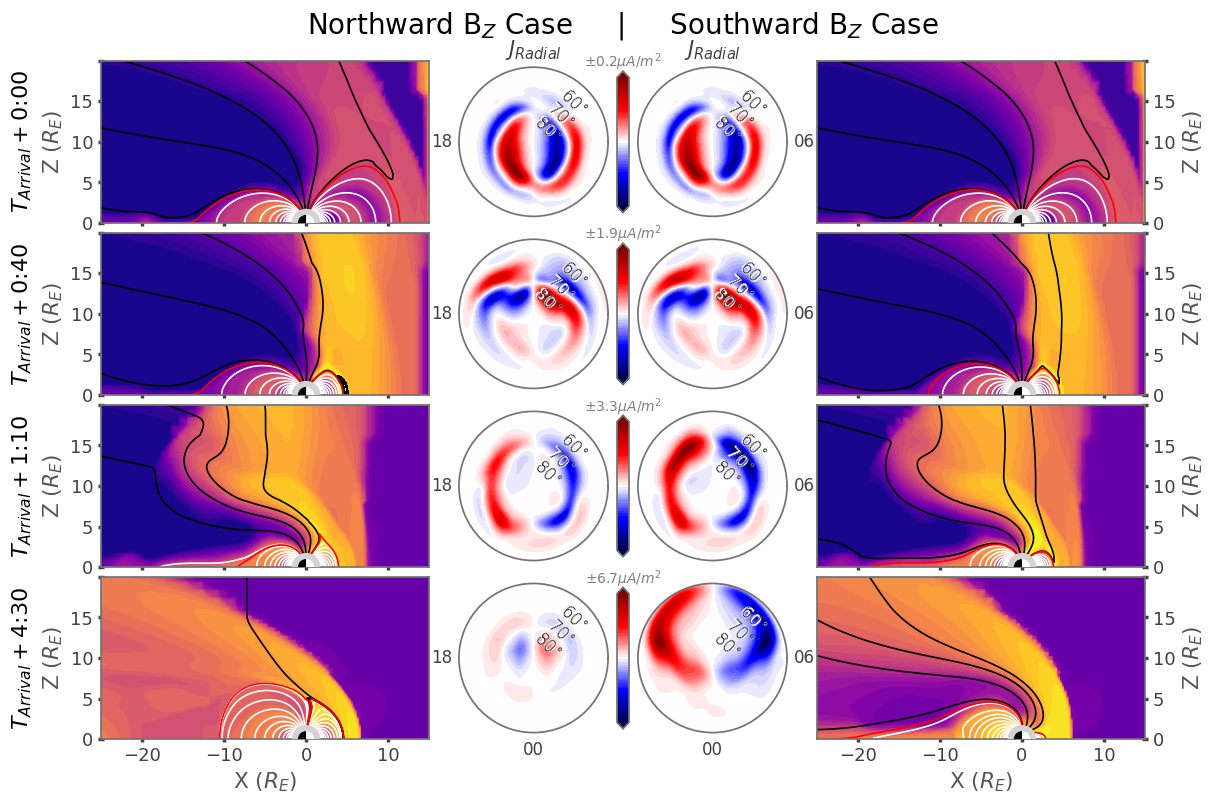

In [ ]:
# Gather common plot method kwargs together:
kwargs = {'xlim':[-25,15], 'ylim':[0,20], 'dolog':True}

# Open the MHD data files, which contain the epochs we wish to plot.
# Note that we assume both files have the same number of frames at the exact times. This is
# not always a safe assumption!
mhd_north = bats.Bats2d(os.path.join(path_north, 'GM', 'y=0_mhd_1_e20150321-060040-000_20150321-060510-000.outs'))
mhd_south = bats.Bats2d(os.path.join(path_south, 'GM', 'y=0_mhd_1_e20150321-060040-000_20150321-060510-000.outs'))

# Save time of first frame:
t_start = mhd_north.attrs['time']

# Create figure and set spacing between/around axes.
# These values were obtained via trial & error.
fig = plt.figure(figsize=(12, 7.8))
fig.subplots_adjust(right=.95, bottom=.065, left=.08, top=.935, hspace=.06)
    
# Create gridspec object for placing axes. 4 rows, 6 columns. We'll make
# our magnetosphere plots wider than our ionosphere plots.
grid = gridspec.GridSpec( 4, 6 )

# Loop over the epochs stored in our MHD files.
for i in range(mhd_north.attrs['nframe']):
    # Select the correct frame in our MHD files:
    mhd_north.switch_frame(i)
    mhd_south.switch_frame(i)
        
    # Get information about current epoch:
    t_now = mhd_north.attrs['time']
        
    # Open associated ionosphere files by building file names from the 
    # datetime objects, using f-strings, and being aware of the power of 
    # the string formatting mini-language. Alternativel, the glob module is
    # helpful.
    iono_north = rim.Iono(os.path.join(path_north, "IE", f"it{t_now:%y%m%d_%H%M%S}_000.idl.gz"))
    iono_south = rim.Iono(os.path.join(path_south, "IE", f"it{t_now:%y%m%d_%H%M%S}_000.idl.gz"))
        
    # Get plot ranges for IE plots - absolute maximum from BOTH simulations.
    maxz = max( np.abs(iono_north['n_jr']).max(), np.abs(iono_south['n_jr']).max())
    # Get plot ranges for GM plots - small to max for both simulations.
    zlim=[0.005, max(mhd_north['p'].max(), mhd_south['p'].max())]
        
    # Add magsphere plots: Start by creating axes that are wider than tall 
    # using our gridspec object:
    a1, a2 = fig.add_subplot(grid[i,:2]), fig.add_subplot(grid[i,4:])
    # Plot our contours to each using our common plot kwargs.
    # The "out" variables capture the returned values as tuples.
    out1 = mhd_north.add_contour('x','z','p',target=a1, zlim=zlim, **kwargs) 
    out2 = mhd_south.add_contour('x','z','p',target=a2, zlim=zlim, **kwargs)
    # Add magnetic field lines to both.
    mhd_north.add_b_magsphere(a1)#, tol=0.000001)
    mhd_south.add_b_magsphere(a2)#, tol=0.000001)
        
    # Now add FAC plots. Start by creating axes objects...
    a3 = fig.add_subplot(grid[i,2], polar=True)
    a4 = fig.add_subplot(grid[i,3], polar=True)
    # Plot to each axes. Again, "out" variables catpure all returned objects.
    out1 = iono_north.add_cont('n_jr', target=a3, maxz=maxz, extend='both')
    out2 = iono_south.add_cont('n_jr', target=a4, maxz=maxz, extend='both')

    # Add color bar between FAC plots. Start by getting the bounding box
    # for each axes, use that position to set where to place color bar.
    b1 = a3.get_position()
    b2 = a4.get_position()
    center = b1.x1 + (b2.x0-b1.x1)/2.
    # Create color bar axes:
    ax = fig.add_axes( [center-.005, b1.y0+.005, .01, b1.y1-b1.y0-.01] )
    # Add color bar to axes. "out1[2]" is the matplotlib contour object from
    # the FAC contour plot returned by the `add_cont` method.
    cbar = plt.colorbar(out1[2], cax=ax)
    cbar.set_ticks([])
    # Add label to cbar:
    fig.text(center, b1.y1, '$\\pm${:.1f}$\\mu A/m^2$'.format(maxz),
             color='gray',ha='center', size=10)
        
    # Fit and finish: fix overlapping titles/labels, properly label epochs and simulations:
    # Add epoch labels to leftmost plot using bounding box to get the position:
    box = a1.get_position()
    x = .014
    y = (box.y1-box.y0)/2. + box.y0
    # Get the time from frame zero:
    delT = (t_now - t_start).total_seconds() # total seconds from first frame...
    mins = int(np.floor(delT/60.)) # Get minutes...
    secs = np.abs(int(delT - 60*mins)) # get seconds...
    # Add text to first figure:
    fig.text(x,y,'$T_{{Arrival}}+${0:01d}:{1:02d}'.format(mins,secs),
             ha='center',va='center',rotation=90, size=16)
        
    # Adjust plots labels
    # Put tick labels on right side of rightmost plot:
    a2.yaxis.set_label_position("right")
    a2.yaxis.tick_right()
    # Turn off redundant labels
    if i < mhd_north.attrs['nframe'] - 1: 
        # Turn off labels if we're not on the last row...
        a1.set_xlabel('')
        a2.set_xlabel('')
        a1.set_xticklabels('')
        a2.set_xticklabels('')
            
    # Set dial plot tick labels (x-axes tick labels)
    top, bottom = '', '' # Default top/bottom labels are blank.
    if i == 0: 
        top = r'$J_{Radial}$' # Label top of dials for top row
    if i == mhd_north.attrs['nframe'] - 1: 
        bottom='00' # Label bottom of dials for bottom row.
    # Apply tick labels to each dial plot.
    a3.set_xticklabels(['',   top, '18', bottom])
    a4.set_xticklabels(['06', top,   '', bottom])
        
    # Turn off topmost tick label on MHD plots, which overlap with other plots:
    plt.setp(a1.get_yticklabels()[-1], visible=False) 
    plt.setp(a2.get_yticklabels()[-1], visible=False)
        
# Finally, some text labels to distinguish the northward and southward cases:
# Use the bounding box for our color bar axes object as a guide:
box = ax.get_position()
x = (box.x1-box.x0)/2 +  box.x0
# Create and apply centered text at the top of the figure:
fig.text(x, .97, 'Northward B$_Z$ Case     |     Southward B$_Z$ Case', size=20, ha='center')

This is nearly the final plot in the actual publication. Note that most of the work isn't opening and manipulating data; rather it is in polishing the figure to create a publication-worthy image. When creating complex figures like this, I recommend sketching out your vision for the plot, then playing in IPython to get it where you want it. 

In this figure, there are a lot of good physics on display. We see identical magnetospheres for the first few moments of the storm, including impulse-driven FACs that form on the dayside and propagate to the nightside. We see both simulations yield similar *initial* dayside compression. 70 seconds into the event, the two simluations rapidly diverge. The southward IMF case leads to strong magnetic reconnection, eroding the dayside standoff distance compared to the northward IMF case. The southward case also presents with much stronger and lower-latitude FACs, intensifying the danger to the power grid for this case. 

### Extracting MHD values

The above plot is great, but it could be more *quantitative*, especially concerning the magnetopause stand-off distance. Let's find the stand-off distance for an MHD data frame by *extracting* values from our MHD object. For the purposes of this tutorial, we'll define the stand-off distance as the point where the magnetic field flips from northward to southward. Of course, this only works for the southward IMF case, but it's good enough for this tutorial.

The `Bats2d.extract()` method will interpolate the MHD results to any set of X,Y points. This is extremely useful for extracting values along a stream line or magnetic field line. For our purposes, however, we just want values along the Sun-Earth line, then look for the flip in magnetic field direction.

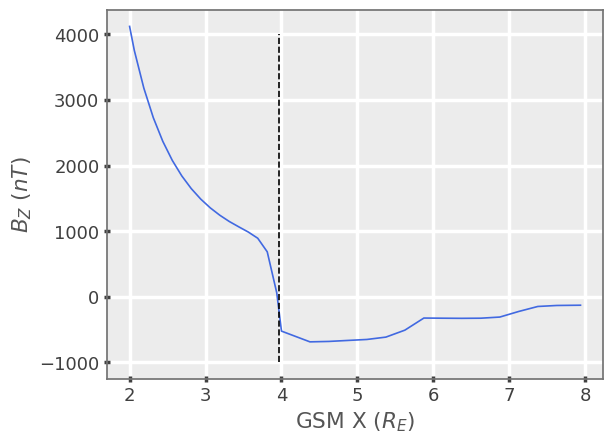

In [ ]:
# Pick a good frame:
mhd_south.switch_frame(2)

# Create arrays of X-Y points and extract to those positions:
x = np.arange(2, 8, 1/16.) # Sun-Earth line
y = np.zeros(x.size) # ...in the equatorial plane.
line = mhd_south.extract(x,y)

# Location of first open-field cell:
x2 = x[line['bz'] < 0.][0]

# Location of last closed-field cell:
x1 = x[line['bz'] > 0.][-1]

# Location is mean of first-and-last closed cell:
boundary = (x1 + x2)/2.

# Create a diagram to show that this works:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(line['x'], line['bz'])
ax.set_ylabel('$B_Z$ ($nT$)')
ax.set_xlabel('GSM X ($R_E$)')

# Place a vertical line at our magnetopause:
ax.vlines(boundary, -1000, 4000, linestyles='dashed', colors='k');

Our magnetopause shows up clearly, and our simple algorithm works! If we did this extraction for *every output file* in our MHD code, and devised a good identification method for the northward IMF case, we could create a time series of stand-off distances. Rather than go through that here, I've stored the values in a Python pickle. Let's open that data file and illustrate our stand-off distance:

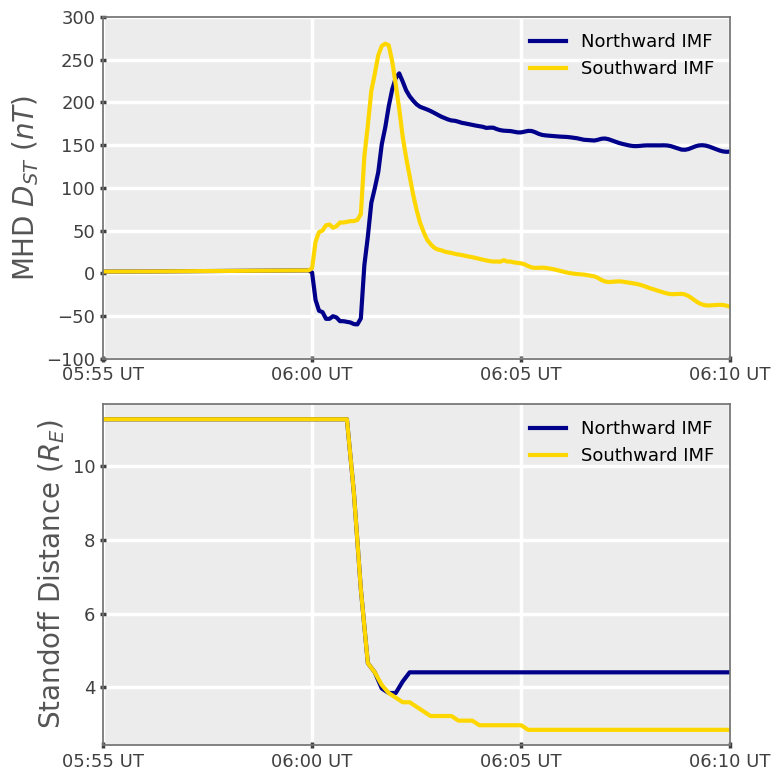

In [ ]:
# Open up stand-off info from our python pickle
with open(os.path.join(tutorial_data, 'standoff_trace_NS.pkl'), 'rb') as f:
    L1 = pickle.load(f)
    L2 = pickle.load(f)
    t = pickle.load(f)
    
# Open both BATS-R-US log files:
logN = pybats.LogFile(os.path.join(path_north, 'GM', 'log_e20150321-054500.log'))
logS = pybats.LogFile(os.path.join(path_south, 'GM', 'log_e20150321-054500.log'))

# Create our figure of appropriate size:
fig=plt.figure(figsize=[8,8])

# First subplot:
ax = fig.add_subplot(211)

# Plot our Dst to give context to stand-off distance values:
ax.plot(logN['time'], logN['dst'], lw=3, label='Northward IMF', c='DarkBlue')
ax.plot(logS['time'], logS['dst'], lw=3, label='Southward IMF', c='Gold')

# Configure our axes to clean things up.
ax.set_ylim([-100,300]) # Set y-axis range
ax.set_ylabel(r'MHD $D_{ST}$ ($nT$)', size=20) # Set labels
splot.applySmartTimeTicks(ax, t, dolabel=False) # Configure time axis.
ax.legend() # Add a legend using the labels in our plotting function.

# Now plot stand-off distance of dayside magnetosphere.
# Second subplot:
ax = fig.add_subplot(212)

# Plot and label and configure...
ax.plot(t, L1, lw=3, label='Northward IMF', c='DarkBlue')
ax.plot(t, L2, lw=3, label='Southward IMF', c='Gold')
ax.set_ylabel('Standoff Distance ($R_E$)', size=20)
splot.applySmartTimeTicks(ax, t)
ax.legend()

# Clean up the plot layout:
fig.tight_layout()

...and that's it! We illustrated our model results and extracted useful values. Of note here is the huge rise in Dst, the apparent "precursor" signature that occurs before the CME contacts the bow shock, and the fact that the southward IMF case produces a magnetopause that is ~2 Earth Radii upstream- only 1 R<sub>E</sub> from the Earth's surface!


## Epilogue
In this tutorial, we had worked through a crash-course on using Pybats to explore output from the SWMF, create illustrative figures, and extract values to create quantitative comparisons. There's much, much more however - including automatic data fetching, advanced stream tracing, and many, many classes to handle a variety of outputs. I recommend perusing Pybats and its submodules with IPython's tab-complete capabilities and reading the docstrings.

Overall, much of the capability here is built on Spacepy's `datamodel` package. If you can use that, you can navigate SWMF output without much confusion.
